### Score: `[51]`

1.1 `[16]` Great job!

1.2 `[19]` Good job!

1.3 `[5]` Good job!

[Bonus] `[11]`

各题批注用`### Note`给出，请自行查阅。

In [10]:
# Assignment 05 by Yi Yang
import scipy
import pandas as pd
import numpy as np
from scipy import constants
from scipy.interpolate import UnivariateSpline
from numpy import exp
from scipy import integrate
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import xlrd
%matplotlib inline
from scipy.integrate import odeint

In [12]:
# 1.1 Build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.
df1=pd.read_csv('global.1751_2014.csv')
df1

,Year,Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C),Carbon emissions from gas fuel consumption,Carbon emissions from liquid fuel consumption,Carbon emissions from solid fuel consumption,Carbon emissions from cement production,Carbon emissions from gas flaring,Per capita carbon emissions (metric tons of carbon; after 1949 only)
0,1751,3,0,0,3,0,0,NaN
1,1752,3,0,0,3,0,0,NaN
2,1753,3,0,0,3,0,0,NaN
3,1754,3,0,0,3,0,0,NaN
4,1755,3,0,0,3,0,0,NaN
...,...,...,...,...,...,...,...,...
259,2010,9128,1696,3107,3812,446,67,1.32
260,2011,9503,1756,3134,4055,494,64,1.36
261,2012,9673,1783,3200,4106,519,65,1.36
262,2013,9773,1806,3220,4126,554,68,1.36


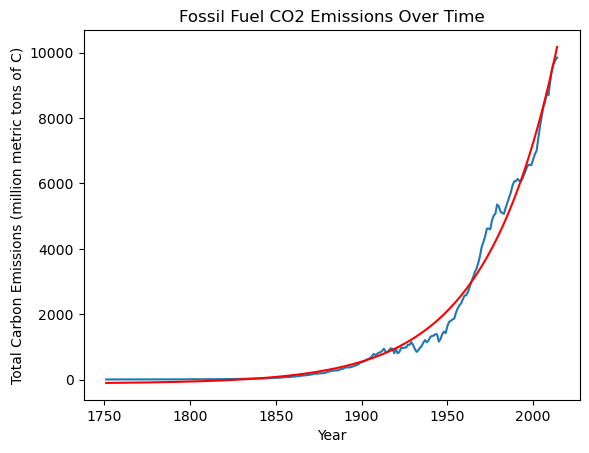

[ 2.39596800e-02 -3.90147674e+01 -1.22229282e+02]


In [18]:
# 本题我请教了我的师姐龙师倩
# 定义拟合函数，使用指数模型拟合化石燃料排放的二氧化碳随时间变化的曲线
def fossil_emiss(x, a1, a2, a3): 
    """
    拟合函数，形式为 y = exp(a1*x + a2) + a3
    :param x: 年份
    :param a1: 指数模型的系数
    :param a2: 指数模型的指数
    :param a3: 指数模型的偏移量
    :return: 拟合的二氧化碳排放量
    """
    return np.exp(a1 * x + a2) + a3

# 设置拟合的初始值
a1 = 0.1  # 指数系数的初始值
a2 = 0.1  # 指数的初始值
a3 = 0     # 偏移量的初始值
p0 = [a1, a2, a3]  # 初始参数值列表

# 调用拟合函数，确保数据列的数据类型为整数
df1['Year'].astype(int)
df1['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'].astype(int)

# 使用curve_fit进行曲线拟合
para,cov = optimize.curve_fit(fossil_emiss, df1['Year'], df1['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'],p0=p0)

# 绘制真实数据点
plt.plot(df1['Year'],df1['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'],label='Actual Data')
# 绘制拟合曲线
plt.plot(df1['Year'], fossil_emiss(df1['Year'], *para), '-', label='Fitted Curve', color='red')

# 添加图表标题和标签
plt.title('Fossil Fuel CO2 Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Total Carbon Emissions (million metric tons of C)')

plt.show()
print(para)

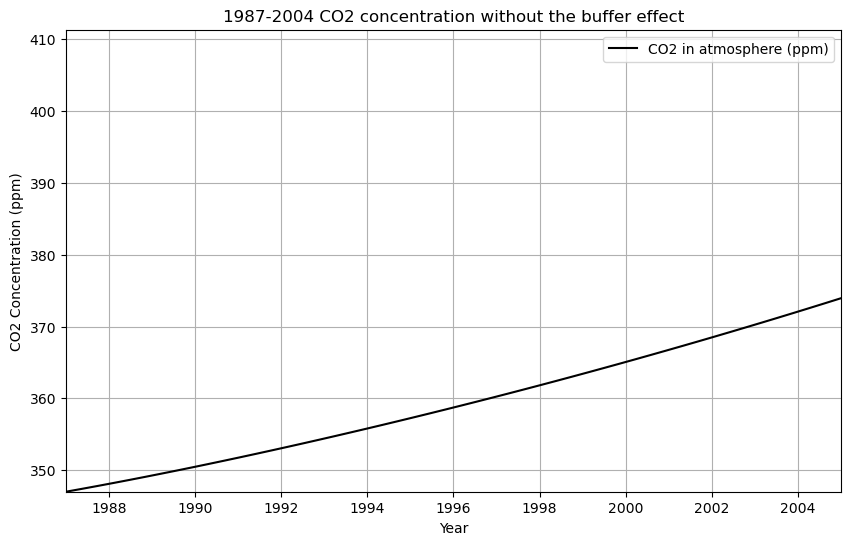

In [40]:
# https://zhuanlan.zhihu.com/p/484167038
# 定义没有buffer效应的碳循环函数
def model1(y,t,k12,k21):
    """
    碳循环模型，不考虑buffer效应。
    :param y: 状态变量数组，包含大气中的CO2浓度(N1)，海洋中的CO2浓度(N2)，以及γ(a)。
    :param t: 时间变量。
    :param k12: 从大气到海洋的CO2转移率。
    :param k21: 从海洋到大气的CO2转移率。
    :return: 状态变量的导数数组。
    """
    N1,N2,a = y #a是γ
    ### Note: γ的值可以通过处理“global.1751_2008.csv”获取
    dydt=[-k12*N1+k21*N2+a,k12*N1-k21*N2,2.39596800e-02*a+2.39596800e-02*1.22229282e+02]
    return dydt
    
# 设置初始值
t1=np.linspace(1987, 2005) 
a=fossil_emiss(t1,*para)  # 使用之前拟合的函数计算γ值
k12=105/740   # 从大气到海洋的CO2转移率
k21=102/900   # 从海洋到大气的CO2转移率
N1=740*1000   # 大气中的CO2浓度初始值
N2=900*1000   # 海洋中的CO2浓度初始值
y0=[N1,N2,a[0]] 

# 解决常微分方程
sol = odeint(model1, y0, t1, args=(k12,k21))/1000/740*347  # 转换单位

plt.figure(figsize=(10, 6))  # 设置图表大小
plt.plot(t1, sol[:, 0], 'k', label='CO2 in atmosphere (ppm)')  # 绘制大气中的CO2浓度
# 添加图例
plt.legend(loc='best')
# 设置横坐标轴刻度为整数
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# 设置图表标题和坐标轴标签
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)') ### Note: CO$_2$，注意标题下标小写更好~
# 设置横坐标轴的范围
plt.xlim([t1[0], t1[-1]])
# 设置纵坐标轴的范围
plt.ylim([sol[:, 0].min(), sol[:, 0].max() * 1.1])  # 纵坐标轴范围为最小值到最大值的1.1倍
plt.grid(True)
plt.title('1987-2004 CO2 concentration without the buffer effect')
plt.show()

In [42]:
# 1.2 Build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.
# 定义有buffer效应的函数
def model2(y,t,k12,k21,N0):
    """
    碳循环模型，考虑buffer效应。
    :param y: 状态变量数组，包含大气中的CO2浓度(N1)，海洋中的CO2浓度(N2)，以及γ(a2)。
    :param t: 时间变量。
    :param k12: 从大气到海洋的CO2转移率。
    :param k21: 从海洋到大气的CO2转移率。
    :param N0: 海洋中的CO2平衡浓度。
    :return: 状态变量的导数数组。
    """
    N1,N2,a2 = y
    bf=3.69+1.86e-2*(N1/740/1000*347)-1.8e-6*((N1/740/1000*347)**2) #buffer factor
    dydt=[-k12*N1+k21*(N0+bf*(N2-N0))+a2,
          k12*N1-k21*(N0+bf*(N2-N0)),
          2.39596800e-02*a2+2.39596800e-02*1.22229282e+02]
    return dydt
# 设置初始值
t2=np.linspace(0, 253, 253)+1751 
a2=fossil_emiss(t2,*para)

k12=105/740
k21=102/900
N0=821*1000
N1=618*1000
N2=821*1000
y0=[N1,N2,a2[0]] 

# 解决常微分方程，并且转化为ppm的单位
sol2 = odeint(model2, y0, t2, args=(k12,k21,N0))/740/1000*347 #计算微分方程，并且转化为ppm的单位
sol2

array([[ 2.89791892e+02,  3.84982432e+02, -4.84577482e-02],
       [ 2.91238045e+02,  3.83487737e+02, -4.82420907e-02],
       [ 2.91660746e+02,  3.83016713e+02, -4.80211828e-02],
       [ 2.91763603e+02,  3.82865757e+02, -4.77948966e-02],
       [ 2.91766902e+02,  3.82814589e+02, -4.75631011e-02],
       [ 2.91739337e+02,  3.82794521e+02, -4.73256623e-02],
       [ 2.91702311e+02,  3.82784156e+02, -4.70824426e-02],
       [ 2.91662489e+02,  3.82776834e+02, -4.68333014e-02],
       [ 2.91621951e+02,  3.82770480e+02, -4.65780946e-02],
       [ 2.91581350e+02,  3.82764449e+02, -4.63166743e-02],
       [ 2.91540891e+02,  3.82758540e+02, -4.60488894e-02],
       [ 2.91500644e+02,  3.82752693e+02, -4.57745849e-02],
       [ 2.91460633e+02,  3.82746889e+02, -4.54936021e-02],
       [ 2.91420870e+02,  3.82741121e+02, -4.52057783e-02],
       [ 2.91381363e+02,  3.82735390e+02, -4.49109471e-02],
       [ 2.91342120e+02,  3.82729695e+02, -4.46089378e-02],
       [ 2.91303146e+02,  3.82724038e+02

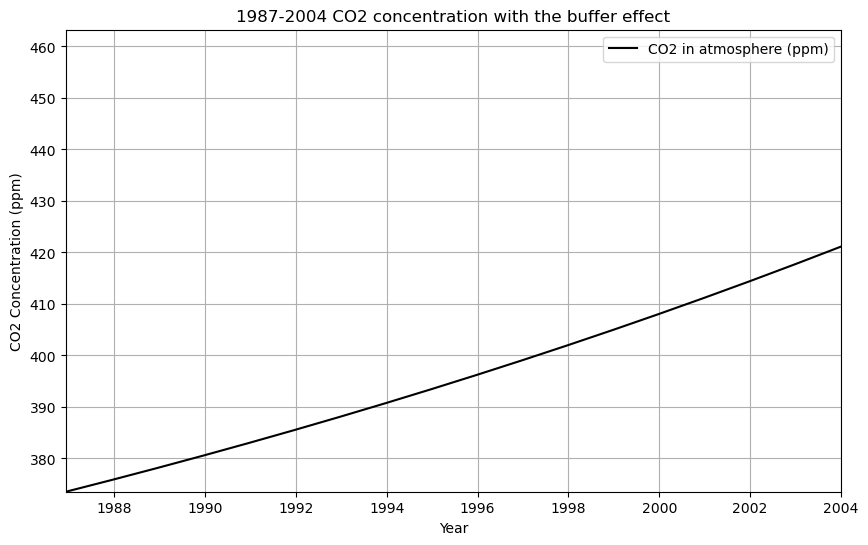

In [52]:
# 画图
plt.figure(figsize=(10, 6))  # 设置图表大小
# 绘制1987年到2004年间大气中CO2浓度的变化
plt.plot(t2[235:253], sol2[235:253, 0], 'k', label='CO2 in atmosphere (ppm)')
# 添加图例
plt.legend(loc='best')
# 设置横坐标轴刻度为整数
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# 设置图表标题和坐标轴标签
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.xlim([t2[235], t2[252]])  # 设置横坐标轴的范围为1987年到2004年
plt.ylim([sol2[235:253, 0].min(), sol2[235:253, 0].max() * 1.1])  # 设置纵坐标轴的范围为最小值到最大值的1.1倍
plt.grid(True)
plt.title('1987-2004 CO2 concentration with the buffer effect')
plt.show()

In [28]:
# 1.3 Reproduce Figure 2 in Tomizuka (2009).
# 导入观测值数据
df2=pd.read_csv('co2_annmean_mlo.csv')
df2

,year,mean,unc
0,1959,315.98,0.12
1,1960,316.91,0.12
2,1961,317.64,0.12
3,1962,318.45,0.12
4,1963,318.99,0.12
...,...,...,...
59,2018,408.72,0.12
60,2019,411.65,0.12
61,2020,414.21,0.12
62,2021,416.41,0.12


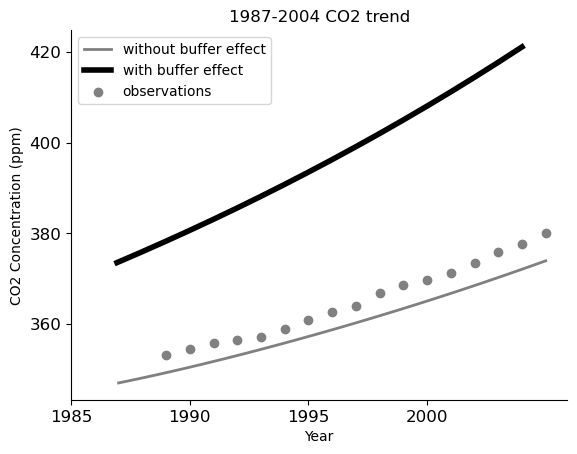

In [54]:
# 画图
plt.plot(t1, sol[:, 0], linewidth=2, color='grey') # without buffer effect
plt.plot(t2[235:253], sol2[235:253,0], linewidth=4, color='black') # with buffer effect
plt.scatter(df2['year'][30:47],df2['mean'][30:47], color='gray') # observed data
# 设置图例
plt.legend(['without buffer effect','with buffer effect','observations'],loc='best')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
# 设置横纵坐标
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.xticks([1985, 1990, 1995, 2000], fontsize=12)
plt.yticks([360, 380, 400, 420], fontsize=12)
# 隐藏右边和上边的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('1987-2004 CO2 trend')
plt.show()
# 不考虑buffer effect的曲线与文献中图2略有区别，可能是函数拟合不够好

In [62]:
# [Bonus] Compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).
# 本题我向我的师姐龙师倩寻求了帮助
co2_observations = pd.read_csv('1750-2000CO2.csv')
land_use_data = pd.read_excel('Global_land-use_flux-1750_2005.xls')
ff_emissions = pd.read_csv('global.1751_2014.csv')

# 选择需要的列，并计算土地利用变化导致的CO2排放量
land_use_data = land_use_data[['Year', 'Global']]
land_use_data['LandUseChange'] = land_use_data['Global'] / (1000 * 2.13)

# 选择需要的列，并计算化石燃料燃烧导致的CO2排放量
ff_emissions = ff_emissions[['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)', 'Carbon emissions from cement production']]
ff_emissions['FossilFuelEmissions'] = ff_emissions.iloc[:, 1] - ff_emissions.iloc[:, 2]
ff_emissions['EmissionFactor'] = ff_emissions['FossilFuelEmissions'] / (1000 * 2.13)

In [58]:
# 定义碳循环模型中的参数
k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71 = [60 / 615, 60 / 842, 9 / 842, 43 / 842, 52 / 9744, 162 / 9744, 205 / 26280, 0.2 / 26280, 0.2 / 90000000, 62 / 731, 62 / 1238] ### Note: 文献中为1328
N2_0 = 842 / 2.13

# 定义初始条件
initial_conditions = [615 / 2.13, 842 / 2.13, 9744 / 2.13, 26280 / 2.13, 90000000 / 2.13, 731 / 2.13, 1238 / 2.13] 
f0 = 62 / 2.13
P0 = 615 / 2.13

# 探索Beta值
beta_values = [0.38, 0.5]
results = []

for beta in beta_values:
    # 复制初始条件
    N1, N2, N3, N4, N5, N6, N7 = initial_conditions.copy()
    atmosphere = [N1]
    
    for year in range(1751, 2001):
        gamma = ff_emissions[ff_emissions['Year'] == year]['EmissionFactor'].values[0]
        delta = land_use_data[land_use_data['Year'] == year]['LandUseChange'].values[0]

        xi = 3.69 + 0.0186 * N1 - 0.0000018 * N1**2

        f = f0 * (1 + beta * np.log(N1 / P0))
        
         # 计算每个部分的变化率
        dN1_dt = -k12 * N1 + k21 * (N2_0 + xi * (N2 - N2_0)) + gamma - f + delta + k51 * N5 + k71 * N7
        dN2_dt = k12 * N1 - k21 * (N2_0 + xi * (N2 - N2_0)) - k23 * N2 + k32 * N3 - k24 * N2
        dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
        dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
        dN5_dt = k45 * N4 - k51 * N5
        dN6_dt = f - k67 * N6 - 2 * delta
        dN7_dt = k67 * N6 - k71 * N7 + delta

        # 更新每个部分的值
        N1 += dN1_dt
        N2 += dN2_dt
        N3 += dN3_dt
        N4 += dN4_dt
        N5 += dN5_dt
        N6 += dN6_dt
        N7 += dN7_dt

        atmosphere.append(N1)
    
    # 将atmosphere列表添加到results列表中
    results.append(atmosphere)

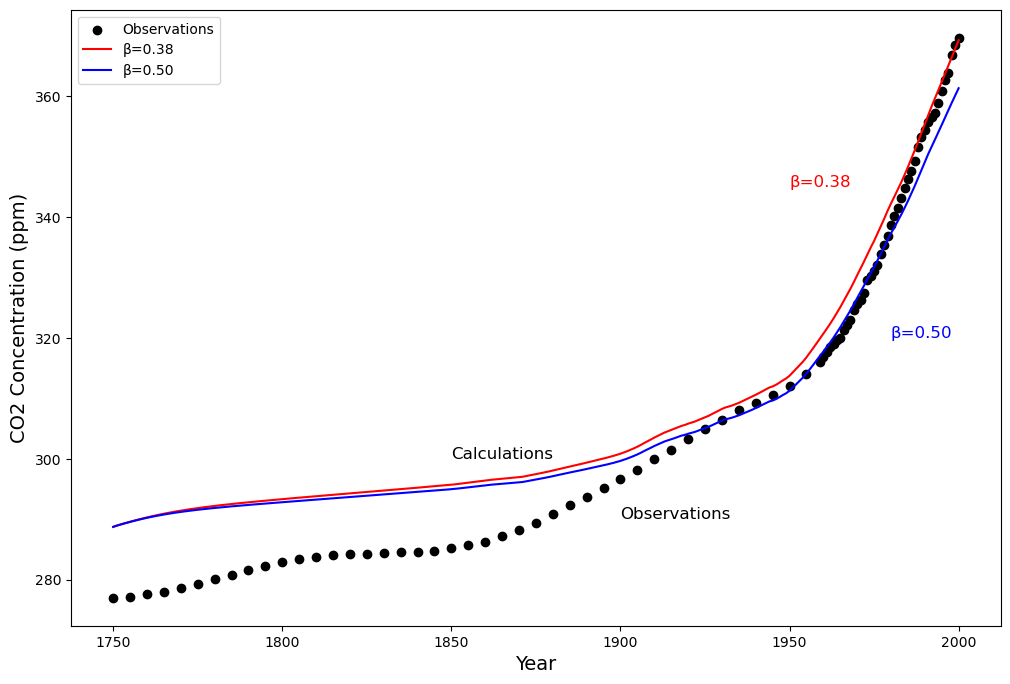

In [60]:
plt.figure(figsize=(12, 8))

plt.scatter(co2_observations['year'], co2_observations['mean'], label='Observations', color='black')

plt.text(1850, 300, 'Calculations', fontsize=12)
plt.text(1900, 290, 'Observations', fontsize=12)
plt.text(1950, 345, 'β=0.38', fontsize=12, color='red')
plt.text(1980, 320, 'β=0.50', fontsize=12, color='blue')

# 直接画出每个beta值的结果，用红色和蓝色表示
plt.plot(range(1750, 2001), results[0], color='red', label='β=0.38')
plt.plot(range(1750, 2001), results[1], color='blue', label='β=0.50')

plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=14)

plt.legend()

plt.show()